In [33]:
import numpy as np
import matplotlib.pyplot as plt

class MelSpectrogram:
    def __init__(self, sample_rate=22050, n_fft=2048, hop_length=512, 
                 n_mels=128, fmin=0.0, fmax=None):
        """
        Initialize Mel Spectrogram parameters.
        
        Args:
            sample_rate: Audio sample rate in Hz
            n_fft: FFT window size
            hop_length: Number of samples between successive frames
            n_mels: Number of mel frequency bins
            fmin: Minimum frequency (Hz)
            fmax: Maximum frequency (Hz), defaults to sample_rate/2
        """
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax if fmax else sample_rate / 2.0
        
        # Create mel filterbank
        self.mel_filters = self._create_mel_filterbank()
    
    def _hz_to_mel(self, hz):
        """Convert Hz to mel scale."""
        return 2595 * np.log10(1 + hz / 700.0)
    
    def _mel_to_hz(self, mel):
        """Convert mel scale to Hz."""
        return 700 * (10**(mel / 2595.0) - 1)
    
    def _create_mel_filterbank(self):
        """Create mel filterbank matrix."""
        # Number of frequency bins in STFT
        n_freqs = self.n_fft // 2 + 1
        
        # Create mel-spaced frequency points
        mel_min = self._hz_to_mel(self.fmin)
        mel_max = self._hz_to_mel(self.fmax)
        mel_points = np.linspace(mel_min, mel_max, self.n_mels + 2)
        hz_points = self._mel_to_hz(mel_points)
        
        # Convert Hz points to FFT bin numbers
        # FIXED: Use correct formula
        bin_points = np.floor((self.n_fft + 1) * hz_points / self.sample_rate).astype(int)
        
        # Ensure bins are within valid range
        bin_points = np.clip(bin_points, 0, n_freqs - 1)
        
        print(f"DEBUG: Mel filterbank creation")
        print(f"  n_freqs: {n_freqs}")
        print(f"  mel_min: {mel_min:.2f}, mel_max: {mel_max:.2f}")
        print(f"  hz range: {hz_points[0]:.2f} to {hz_points[-1]:.2f} Hz")
        print(f"  bin range: {bin_points[0]} to {bin_points[-1]}")
        print(f"  bin_points sample: {bin_points[:5]}")
        
        # Create filterbank
        filterbank = np.zeros((self.n_mels, n_freqs))
        
        for i in range(self.n_mels):
            # Left, center, right points for triangular filter
            left = bin_points[i]
            center = bin_points[i + 1]
            right = bin_points[i + 2]
            
            print(f"  Filter {i}: left={left}, center={center}, right={right}")
            
            # Skip if points are the same (shouldn't happen but just in case)
            if left == center == right:
                continue
            
            # Rising slope: from left to center
            if center > left:
                for j in range(left, center):
                    filterbank[i, j] = (j - left) / (center - left)
            
            # Falling slope: from center to right
            if right > center:
                for j in range(center, right):
                    filterbank[i, j] = (right - j) / (right - center)
        
        print(f"  Filterbank non-zero elements: {np.count_nonzero(filterbank)}")
        print(f"  Filterbank max: {filterbank.max():.6f}")
        
        return filterbank
    
    def _stft(self, audio):
        """Compute Short-Time Fourier Transform."""
        # Check if audio is long enough
        if len(audio) < self.n_fft:
            # Pad audio if too short
            audio = np.pad(audio, (0, self.n_fft - len(audio)), mode='constant')
        
        # Apply Hann window
        window = np.hanning(self.n_fft)
        
        # Calculate number of frames
        n_frames = max(1, 1 + (len(audio) - self.n_fft) // self.hop_length)
        
        # Initialize STFT matrix
        stft_matrix = np.zeros((self.n_fft // 2 + 1, n_frames), dtype=np.complex128)
        
        # Compute STFT
        for i in range(n_frames):
            start = i * self.hop_length
            end = start + self.n_fft
            
            # Handle edge case where we need padding
            if end > len(audio):
                frame = np.pad(audio[start:], (0, end - len(audio)), mode='constant')
            else:
                frame = audio[start:end]
            
            # Apply window
            frame = frame * window
            
            # Compute FFT and take only positive frequencies
            fft_frame = np.fft.rfft(frame, n=self.n_fft)
            stft_matrix[:, i] = fft_frame
        
        return stft_matrix
    
    def transform(self, audio):
        """
        Compute mel spectrogram from audio signal.
        
        Args:
            audio: 1D numpy array of audio samples
            
        Returns:
            Mel spectrogram (n_mels x n_frames)
        """
        # Ensure audio is 1D numpy array
        audio = np.asarray(audio).flatten()
        
        if len(audio) == 0:
            raise ValueError("Audio signal is empty")
        
        # Compute STFT
        stft = self._stft(audio)
        
        # Compute power spectrogram
        power_spec = np.abs(stft) ** 2
        
        # Apply mel filterbank
        mel_spec = np.dot(self.mel_filters, power_spec)
        
        return mel_spec
    
    def transform_db(self, audio, ref=None, amin=1e-10, top_db=80.0):
        """
        Compute mel spectrogram in dB scale.
        
        Args:
            audio: 1D numpy array of audio samples
            ref: Reference power (None = use max value)
            amin: Minimum amplitude threshold
            top_db: Maximum dB range
            
        Returns:
            Mel spectrogram in dB (n_mels x n_frames)
        """
        mel_spec = self.transform(audio)
        
        # Use max as reference if not provided
        if ref is None:
            ref = np.max(mel_spec)
            if ref == 0:
                ref = 1.0
        
        # Convert to dB
        log_spec = 10 * np.log10(np.maximum(amin, mel_spec) / ref)
        
        # Apply top_db limit
        if top_db is not None:
            log_spec = np.maximum(log_spec, log_spec.max() - top_db)
        
        return log_spec

AUDIO DIAGNOSTICS
Sample rate: 22050 Hz
Duration: 30.91 seconds
Number of samples: 681643
Audio min: -0.733933
Audio max: 0.677656
Audio mean: -0.000054
Audio std: 0.154084
Is audio all zeros? False
Non-zero samples: 681643/681643


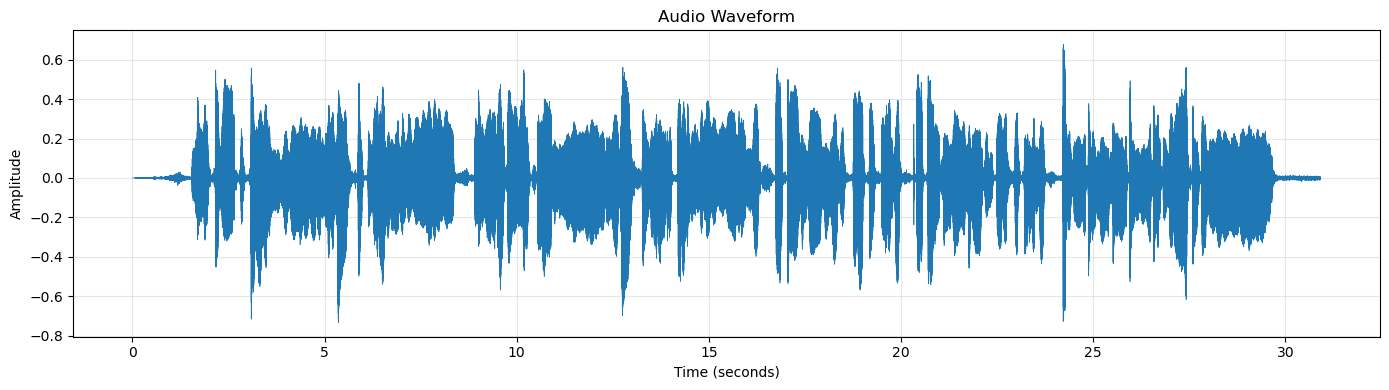


TESTING STFT
First frame:
  Frame min: -0.000655, max: 0.001029
  FFT magnitude min: 0.000000, max: 0.043242
  Power min: 9.163539e-21, max: 1.869890e-03
  Non-zero FFT bins: 1025/1025


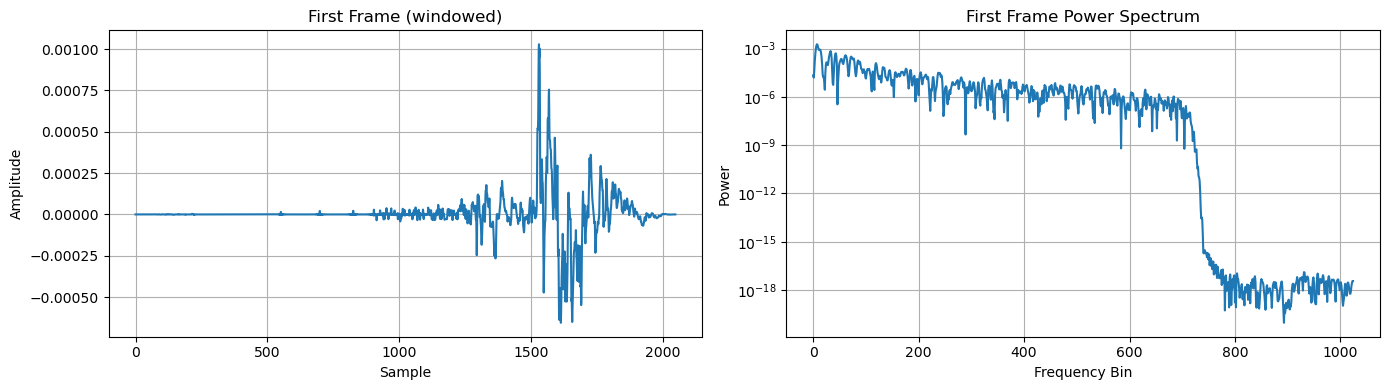


TESTING MEL SPECTROGRAM CLASS
DEBUG: Mel filterbank creation
  n_freqs: 1025
  mel_min: 0.00, mel_max: 3176.32
  hz range: 0.00 to 11025.00 Hz
  bin range: 0 to 1024
  bin_points sample: [0 1 2 4 5]
  Filter 0: left=0, center=1, right=2
  Filter 1: left=1, center=2, right=4
  Filter 2: left=2, center=4, right=5
  Filter 3: left=4, center=5, right=7
  Filter 4: left=5, center=7, right=9
  Filter 5: left=7, center=9, right=10
  Filter 6: left=9, center=10, right=12
  Filter 7: left=10, center=12, right=14
  Filter 8: left=12, center=14, right=15
  Filter 9: left=14, center=15, right=17
  Filter 10: left=15, center=17, right=19
  Filter 11: left=17, center=19, right=21
  Filter 12: left=19, center=21, right=23
  Filter 13: left=21, center=23, right=25
  Filter 14: left=23, center=25, right=27
  Filter 15: left=25, center=27, right=29
  Filter 16: left=27, center=29, right=31
  Filter 17: left=29, center=31, right=33
  Filter 18: left=31, center=33, right=35
  Filter 19: left=33, center=3

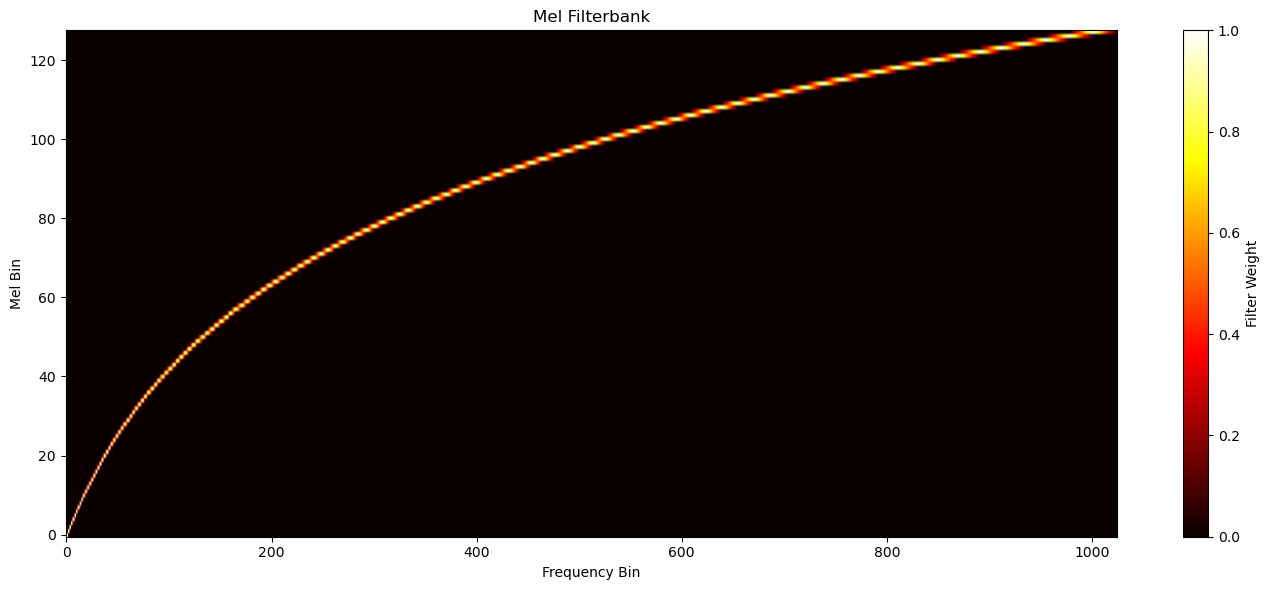


Computing mel spectrogram...
Mel spectrogram shape: (128, 1328)
Mel spec min: 1.861175e-17
Mel spec max: 9.684804e+04
Mel spec mean: 1.461645e+02
Mel spec std: 1.641432e+03
Non-zero values: 169984/169984
Are all values the same? False
Unique values: 169984

Variation per mel bin (std dev):
  Mel bin 0: std = 6.164597e-02, range = [4.338815e-07, 8.215276e-01]
  Mel bin 1: std = 1.432073e-01, range = [3.514895e-05, 2.378384e+00]
  Mel bin 2: std = 1.532681e+00, range = [1.521737e-04, 2.645083e+01]
  Mel bin 3: std = 6.604000e+00, range = [8.340760e-04, 8.339838e+01]
  Mel bin 4: std = 1.134139e+01, range = [3.516699e-03, 1.889263e+02]
  Mel bin 5: std = 7.609920e+00, range = [2.233350e-03, 1.388786e+02]
  Mel bin 6: std = 3.027010e+00, range = [1.382713e-03, 6.432663e+01]
  Mel bin 7: std = 1.621005e+00, range = [3.615213e-04, 3.049379e+01]
  Mel bin 8: std = 3.825182e-01, range = [2.625420e-04, 5.822969e+00]
  Mel bin 9: std = 5.409349e-01, range = [6.400305e-04, 8.851690e+00]

Mel spe

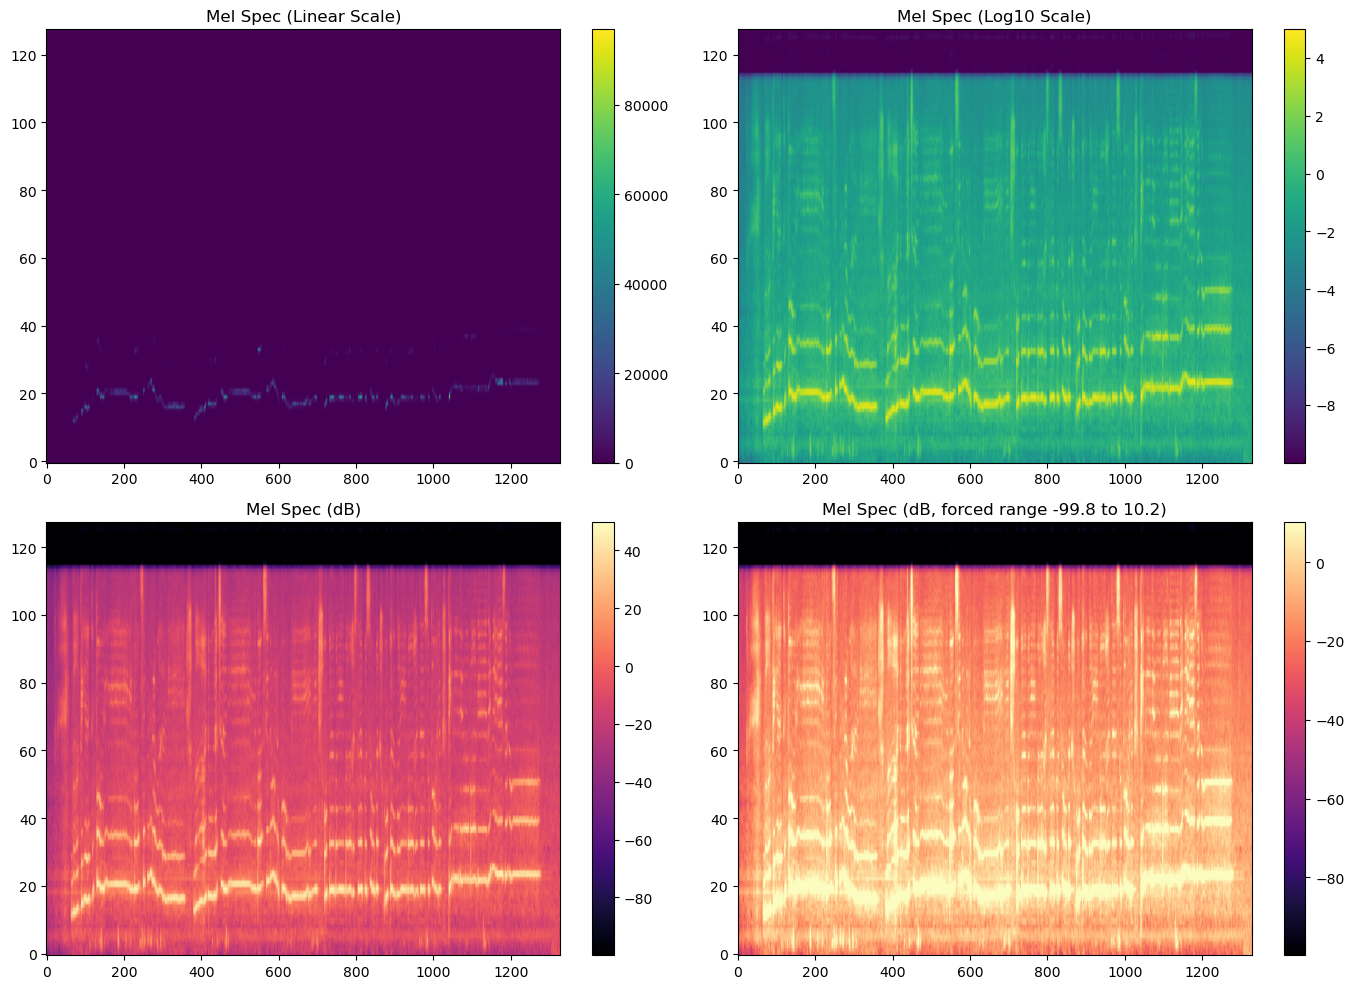


COMPARING WITH LIBROSA
Librosa mel spec shape: (128, 1332)
Librosa mel spec min: 7.272929e-20
Librosa mel spec max: 3.418512e+03
Librosa mel spec dB min: -80.00
Librosa mel spec dB max: 0.00


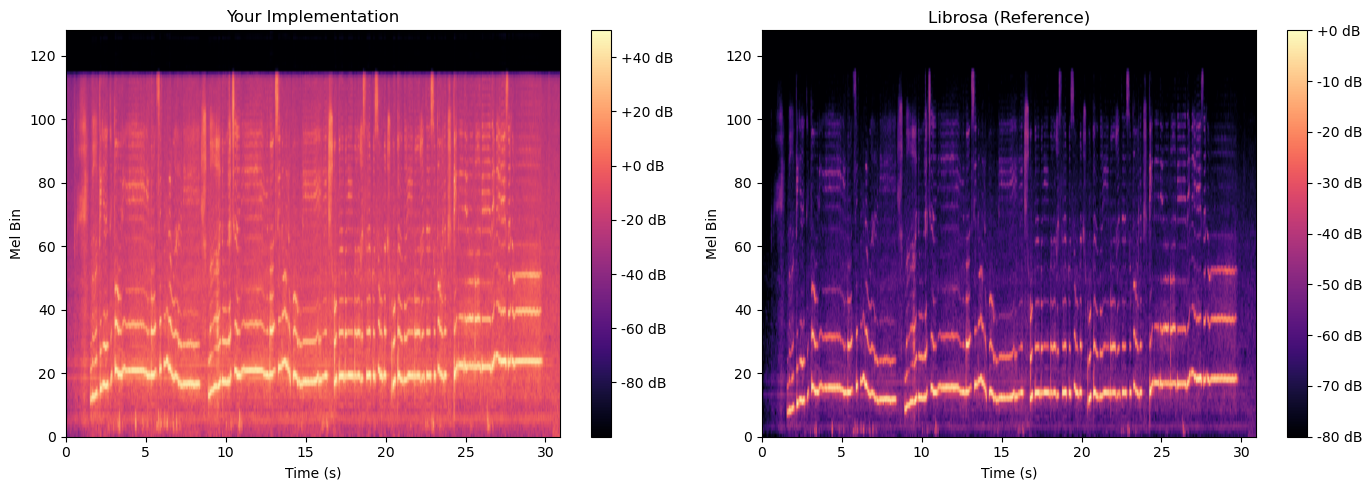

In [34]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load your .ogg file
audio_path = r"C:\\Users\\Isitha\\Downloads\\WhatsApp Audio 2026-02-01 at 23.10.44.ogg"   # UPDATE THIS PATH!
audio, sample_rate = librosa.load(audio_path, sr=22050)

print("="*60)
print("AUDIO DIAGNOSTICS")
print("="*60)
print(f"Sample rate: {sample_rate} Hz")
print(f"Duration: {len(audio)/sample_rate:.2f} seconds")
print(f"Number of samples: {len(audio)}")
print(f"Audio min: {audio.min():.6f}")
print(f"Audio max: {audio.max():.6f}")
print(f"Audio mean: {audio.mean():.6f}")
print(f"Audio std: {audio.std():.6f}")
print(f"Is audio all zeros? {np.allclose(audio, 0)}")
print(f"Non-zero samples: {np.count_nonzero(audio)}/{len(audio)}")

# Plot audio waveform
plt.figure(figsize=(14, 4))
time_axis = np.linspace(0, len(audio)/sample_rate, len(audio))
plt.plot(time_axis, audio, linewidth=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TESTING STFT")
print("="*60)

# Test STFT manually
n_fft = 2048
hop_length = 512
window = np.hanning(n_fft)

# Get first frame
frame1 = audio[:n_fft] * window
fft1 = np.fft.rfft(frame1, n=n_fft)
power1 = np.abs(fft1) ** 2

print(f"First frame:")
print(f"  Frame min: {frame1.min():.6f}, max: {frame1.max():.6f}")
print(f"  FFT magnitude min: {np.abs(fft1).min():.6f}, max: {np.abs(fft1).max():.6f}")
print(f"  Power min: {power1.min():.6e}, max: {power1.max():.6e}")
print(f"  Non-zero FFT bins: {np.count_nonzero(fft1)}/{len(fft1)}")

# Plot first frame FFT
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(frame1)
plt.title('First Frame (windowed)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(power1)
plt.title('First Frame Power Spectrum')
plt.xlabel('Frequency Bin')
plt.ylabel('Power')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TESTING MEL SPECTROGRAM CLASS")
print("="*60)

# Create mel spectrogram calculator
mel_spec_calculator = MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=2048,
    hop_length=512,
    n_mels=128
)

# Check mel filterbank
print(f"Mel filterbank shape: {mel_spec_calculator.mel_filters.shape}")
print(f"Mel filterbank min: {mel_spec_calculator.mel_filters.min():.6f}")
print(f"Mel filterbank max: {mel_spec_calculator.mel_filters.max():.6f}")
print(f"Mel filterbank mean: {mel_spec_calculator.mel_filters.mean():.6f}")
print(f"Non-zero filter values: {np.count_nonzero(mel_spec_calculator.mel_filters)}")

# Visualize mel filterbank
plt.figure(figsize=(14, 6))
plt.imshow(mel_spec_calculator.mel_filters, aspect='auto', origin='lower', cmap='hot')
plt.colorbar(label='Filter Weight')
plt.xlabel('Frequency Bin')
plt.ylabel('Mel Bin')
plt.title('Mel Filterbank')
plt.tight_layout()
plt.show()

# Compute mel spectrogram
print("\nComputing mel spectrogram...")
mel_spec = mel_spec_calculator.transform(audio)

print(f"Mel spectrogram shape: {mel_spec.shape}")
print(f"Mel spec min: {mel_spec.min():.6e}")
print(f"Mel spec max: {mel_spec.max():.6e}")
print(f"Mel spec mean: {mel_spec.mean():.6e}")
print(f"Mel spec std: {mel_spec.std():.6e}")
print(f"Non-zero values: {np.count_nonzero(mel_spec)}/{mel_spec.size}")
print(f"Are all values the same? {len(np.unique(mel_spec)) == 1}")
print(f"Unique values: {len(np.unique(mel_spec))}")

# Check if there's any variation
print(f"\nVariation per mel bin (std dev):")
for i in range(min(10, mel_spec.shape[0])):
    print(f"  Mel bin {i}: std = {mel_spec[i, :].std():.6e}, range = [{mel_spec[i, :].min():.6e}, {mel_spec[i, :].max():.6e}]")

# Convert to dB
mel_spec_db = 10 * np.log10(mel_spec + 1e-10)
print(f"\nMel spec dB min: {mel_spec_db.min():.2f}")
print(f"Mel spec dB max: {mel_spec_db.max():.2f}")
print(f"Mel spec dB range: {mel_spec_db.max() - mel_spec_db.min():.2f}")

# Plot with different settings
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Linear scale
im1 = axes[0, 0].imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
axes[0, 0].set_title('Mel Spec (Linear Scale)')
plt.colorbar(im1, ax=axes[0, 0])

# Log scale
im2 = axes[0, 1].imshow(np.log10(mel_spec + 1e-10), aspect='auto', origin='lower', cmap='viridis')
axes[0, 1].set_title('Mel Spec (Log10 Scale)')
plt.colorbar(im2, ax=axes[0, 1])

# dB scale
im3 = axes[1, 0].imshow(mel_spec_db, aspect='auto', origin='lower', cmap='magma')
axes[1, 0].set_title('Mel Spec (dB)')
plt.colorbar(im3, ax=axes[1, 0])

# dB with forced range
vmin, vmax = np.percentile(mel_spec_db[mel_spec_db > -np.inf], [5, 95])
im4 = axes[1, 1].imshow(mel_spec_db, aspect='auto', origin='lower', cmap='magma', vmin=vmin, vmax=vmax)
axes[1, 1].set_title(f'Mel Spec (dB, forced range {vmin:.1f} to {vmax:.1f})')
plt.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("COMPARING WITH LIBROSA")
print("="*60)

# Compare with librosa
mel_spec_librosa = librosa.feature.melspectrogram(
    y=audio, 
    sr=sample_rate, 
    n_fft=2048, 
    hop_length=512, 
    n_mels=128
)
mel_spec_db_librosa = librosa.power_to_db(mel_spec_librosa, ref=np.max)

print(f"Librosa mel spec shape: {mel_spec_librosa.shape}")
print(f"Librosa mel spec min: {mel_spec_librosa.min():.6e}")
print(f"Librosa mel spec max: {mel_spec_librosa.max():.6e}")
print(f"Librosa mel spec dB min: {mel_spec_db_librosa.min():.2f}")
print(f"Librosa mel spec dB max: {mel_spec_db_librosa.max():.2f}")

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Your implementation
im1 = axes[0].imshow(mel_spec_db, aspect='auto', origin='lower', cmap='magma',
                      extent=[0, len(audio)/sample_rate, 0, 128])
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Mel Bin')
axes[0].set_title('My Implementation')
plt.colorbar(im1, ax=axes[0], format='%+2.0f dB')

# Librosa
im2 = axes[1].imshow(mel_spec_db_librosa, aspect='auto', origin='lower', cmap='magma',
                      extent=[0, len(audio)/sample_rate, 0, 128])
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Mel Bin')
axes[1].set_title('Librosa (Reference)')
plt.colorbar(im2, ax=axes[1], format='%+2.0f dB')

plt.tight_layout()
plt.show()